**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

*Disclaimer*: I have used AI to: 1) help me with some `matplotlib`-syntax and 2) to clarify my use of multi-dimensional (3-D) `numpy` arrays.

In [1]:
# Write your code here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

np.random.seed(404)

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
# firms
A = 1.0
gamma = 0.5

# households
alpha = 0.3
nu = 1.0
epsilon = 2.0

# government
tau = 0.0
T = 0.0

# Question 3
kappa = 0.1

In [3]:
def l_star(p):
    return (p*A*gamma)**(1/(1-gamma))
def y_star(p):
    return A*(l_star(p))**(gamma)
def pi_star(p):
    return ((1-gamma)/(gamma))*(l_star(p))

def utility(c1, c2, L):
    return np.log(c1**alpha*c2**(1-alpha))-nu*(L)**(1+epsilon)/(1+epsilon)

# Consumer's optimal behavior for a given labor supply
def c1_star(L, p1, p2, T):        
        return alpha * (L + T + pi_star(p1) + pi_star(p2)) / p1

def c2_star(L, p1, p2, T, tau):
        return (1 - alpha) * (L + T + pi_star(p1) + pi_star(p2)) / (p2 + tau)

def obj(L, p1, p2, T, tau):
      return np.log((c1_star(L, p1, p2, T))**(alpha) * (c2_star(L, p1, p2, T, tau))**(1-alpha)) - nu * (L**(1+epsilon))/(1+epsilon)

In [4]:
P = (np.linspace(0.1, 2, 10), np.linspace(0.1, 2, 10))
P1 = np.linspace(0.1, 2, 10)
P2 = np.linspace(0.1, 2, 10)

res = []

for p1 in P1:
    for p2 in P2:
        l_star1 = l_star(p1)
        l_star2 = l_star(p2)
        y_star1 = y_star(p1)
        y_star2 = y_star(p2) 

        pi_star1 = pi_star(p1)
        pi_star2 = pi_star(p2)

        res_opt = optimize.minimize(lambda L: -obj(L, p1, p2, T, tau), x0=0, method='BFGS')

        L_star = res_opt.x[0]
        u_star = res_opt.fun

        # Calculate optimal consumption
        c1_star_opt = c1_star(L_star, p1, p2, T)
        c2_star_opt = c2_star(L_star, p1, p2, T, tau)

        # Market clears? (based on loose tolerance)
        cond1 = np.isclose(L_star, l_star1 + l_star2, atol=0.15)
        cond2 = np.isclose(c1_star_opt, y_star1, atol=0.1)
        cond3 = np.isclose(c2_star_opt, y_star2, atol=0.1)

        excess_good1 = abs(c1_star_opt - y_star1)
        excess_good2 = abs(c2_star_opt - y_star2)
        excess_labor = abs(L_star - l_star1 - l_star2)

        res.append({
            'p1': p1.round(2),
            'p2': p2.round(2),
            'goods market clearing': (cond2, cond3),
            'utility': u_star,
            'labor': L_star,
            'labor market clearing': cond1,
            'excess goods': (excess_good1.round(2), excess_good2.round(2)),
            'excess labor': excess_labor.round(2)
        })

import pandas as pd

tab1 = pd.DataFrame(res)
idx_goods = tab1['excess goods'].min()
tab1[tab1['excess goods']==idx_goods]

,p1,p2,goods market clearing,utility,labor,labor market clearing,excess goods,excess labor
46,0.94,1.37,"(True, True)",0.584075,0.815123,True,"(0.01, 0.09)",0.13


**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [5]:
# For which p1, p2 has the lowest market clearing error?
idx_goods = tab1['excess goods'].min()
p1_star, p2_star = tab1[tab1['excess goods']==idx_goods].loc[:, ['p1', 'p2']].values[0]
L_star_opt = tab1[tab1['excess goods']==idx_goods].loc[:, ['labor']].values[0]

print(f'Equilibrium prices (p1, p2)=({p1_star:.2f}, {p2_star:.2f}) as they imply the lowest market clearing error.\nNote that (absolute) tolerance is set to (0.1, 0.15) to take into the imprecision of the numerical optimization.')

Equilibrium prices (p1, p2)=(0.94, 1.37) as they imply the lowest market clearing error.
Note that (absolute) tolerance is set to (0.1, 0.15) to take into the imprecision of the numerical optimization.


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [6]:
# Redefine the government objective function

def obj_gov(X):
      L, p1, p2, T, tau = X

      c1_star_opt = c1_star(L, p1, p2, T)
      c2_star_opt = c2_star(L, p1, p2, T, tau)
      
      util = np.log((c1_star_opt)**(alpha) * (c2_star_opt)**(1-alpha)) - nu * (L**(1+epsilon))/(1+epsilon)

      SWF = util - kappa*y_star(p2)

      return -SWF

# Defining the constraint that the lump sum transfer T = tau * c2_star
def constraint(X):
      L, p1, p2, T, tau = X

      c2_star_opt = c2_star(L, p1, p2, T, tau)
      
      return T - tau * c2_star_opt 

constraints = [{
      'type': 'eq',
      'fun': constraint
}]

# Defining guess and bounds
guess = (0.1, 0.1, 0.1, 0.1, 0.1)
L_bounds = (0, L_star_opt)
p1_bounds = (0.1, p1_star) 
p2_bounds = (0.1, p2_star)
T_bounds = (0.1, 10)
tau_bounds = (0.1, 10)

res_opt = optimize.minimize(obj_gov, x0=(0.1, 0.1, 0.1, 0.1, 0.1), bounds=[L_bounds, p1_bounds, p2_bounds, (0.1, 10), (0.1, 10)], constraints=constraints)
X = res_opt.x

tau_star = X[4]
T_star = X[3]

print(fr'To maximize the social welfare, the government chooses the tax rate tau={tau_star} which implies a lump transfer T={T_star:.2f}.')

To maximize the social welfare, the government chooses the tax rate tau=0.1 which implies a lump transfer T=0.44.


## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [7]:
J = 3
N = 10
K = 10000

F = np.arange(1,N+1)
sigma = 2

v = np.array([1,2,3])
c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


To avoid nested for-loops I use `numpy` to "draw" multi-dimensional arrays.

In [8]:
res = []

eps_ijk = np.random.normal(0, sigma, size=J*K).reshape(J, K)

res.append({
    'u1': v[0] + np.mean(eps_ijk[0, :]),
    'u2': v[1] + np.mean(eps_ijk[1, :]),
    'u3': v[2] + np.mean(eps_ijk[2, :])
})

tab3 = pd.DataFrame(res)
tab3

,u1,u2,u3
0,0.973458,1.996285,2.989331


Evidently, it is most beneficial to, on average, choose career $J=3$. This is not surprising given that we draw $\epsilon^k_{i,j}$ from normal distribution with mean 0, thus:

$\mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \underbrace{\frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k}_{\approx 0}$ 

----
Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

-----

Again, I use multi-dimensional arrays to avoid nested for-loops to save on computation space. I just have to be mindful of my "dimensions".  

In [9]:
# Empty list store my results
res = []

# Helper index which comes in handy later
helper_idx = np.arange(K)

# For grad i = 1, ..., N
for i in range(N): 

    # Draw the error term of their (or friends') error term K times 
    eps_fjk = np.random.normal(0, sigma, size = F[i] * J * K).reshape(F[i], J, K) # F[i], J, K

    # Calculate utility values
    u_bar_ijk = 1/F[i] * (v.reshape(-1,1) + eps_fjk.sum(axis=0)) # J, K

    # Choose career with highest utility
    career_choice = u_bar_ijk.argmax(axis=0) # dim: K --> they choose from the J rows ("axis=0")

    # What is the expected utility of their choice?
    util_prior = u_bar_ijk[career_choice, helper_idx] # J, K 

    # Draw their "own" error term
    eps_ijk = np.random.normal(0, sigma, size=J * K).reshape(J, K) # J, K

    # Calculate their realized utility, again using (career) indices
    util_real = v[career_choice] + eps_ijk[career_choice, :].mean()
    
    # Store graduate type
    grad = i+1

    res.append({
            'career': (career_choice+1),
            'util_prior': util_prior,
            'util_real': util_real,
            'grad_i': grad 
        })

tab4 = pd.DataFrame(res)
print('Okay, now I have "nested" data saved for each graduate type by row. I would also like it in "long" format.')
tab4

Okay, now I have "nested" data saved for each graduate type by row. I would also like it in "long" format.


,career,util_prior,util_real,grad_i
0,"[3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, ...","[4.991656376445848, 1.4390970254741693, 7.4200...","[3.0020159690851416, 2.0020159690851416, 3.002...",1
1,"[1, 2, 1, 3, 1, 3, 3, 1, 3, 2, 3, 3, 2, 3, 2, ...","[2.108359829230152, 4.123977146914077, 1.68105...","[1.0025163918699853, 2.0025163918699853, 1.002...",2
2,"[3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, ...","[1.1854702317720673, 1.767725626056107, 2.3344...","[3.010043928579252, 2.010043928579252, 2.01004...",3
3,"[1, 1, 2, 2, 3, 3, 2, 3, 3, 2, 1, 3, 1, 2, 3, ...","[1.0299450821318747, 1.9429748283244315, 0.687...","[1.0068589768353897, 1.0068589768353897, 2.006...",4
4,"[1, 2, 1, 3, 3, 3, 3, 1, 2, 2, 2, 3, 3, 1, 3, ...","[3.541223795802519, 0.7830299551365305, 1.6771...","[1.0233977415999123, 2.0233977415999123, 1.023...",5
5,"[3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 1, 1, 1, 2, 1, ...","[2.4452139278087284, 2.58921382089207, 0.07011...","[2.9739041785757854, 0.9739041785757853, 2.973...",6
6,"[2, 2, 2, 1, 2, 3, 1, 3, 2, 3, 2, 3, 3, 2, 2, ...","[2.655187305848568, 0.7435503217731255, 1.1688...","[1.9871240246018802, 1.9871240246018802, 1.987...",7
7,"[2, 3, 3, 2, 3, 2, 2, 2, 3, 1, 3, 3, 3, 2, 3, ...","[-0.5259283856878738, 2.0310720928675483, 0.41...","[1.9996844398796563, 2.9996844398796565, 2.999...",8
8,"[2, 2, 1, 1, 3, 3, 1, 1, 3, 3, 2, 1, 2, 2, 1, ...","[0.5382422721092723, 2.4377200040015907, 1.540...","[1.9973342156729599, 1.9973342156729599, 0.997...",9
9,"[1, 1, 1, 2, 1, 1, 3, 2, 3, 3, 2, 1, 3, 1, 3, ...","[0.2188412462856634, 0.880736987439023, 0.7032...","[1.0002797299879496, 1.0002797299879496, 1.000...",10


In [10]:
# To make it "long", I use .explode()
tab4_long = tab4.explode(['career', 'util_prior', 'util_real']).reset_index(drop=True)
tab4_long.head()

,career,util_prior,util_real,grad_i
0,3,4.991656,3.002016,1
1,2,1.439097,2.002016,1
2,3,7.420046,3.002016,1
3,3,5.99856,3.002016,1
4,3,4.666089,3.002016,1


In [11]:
# Now calculate the share of career choice by graduate type
careers_by_grad=tab4_long.value_counts(['career', 'grad_i']).reset_index().sort_values('grad_i').reset_index(drop=True)
careers_by_grad['share']=careers_by_grad['count']/K

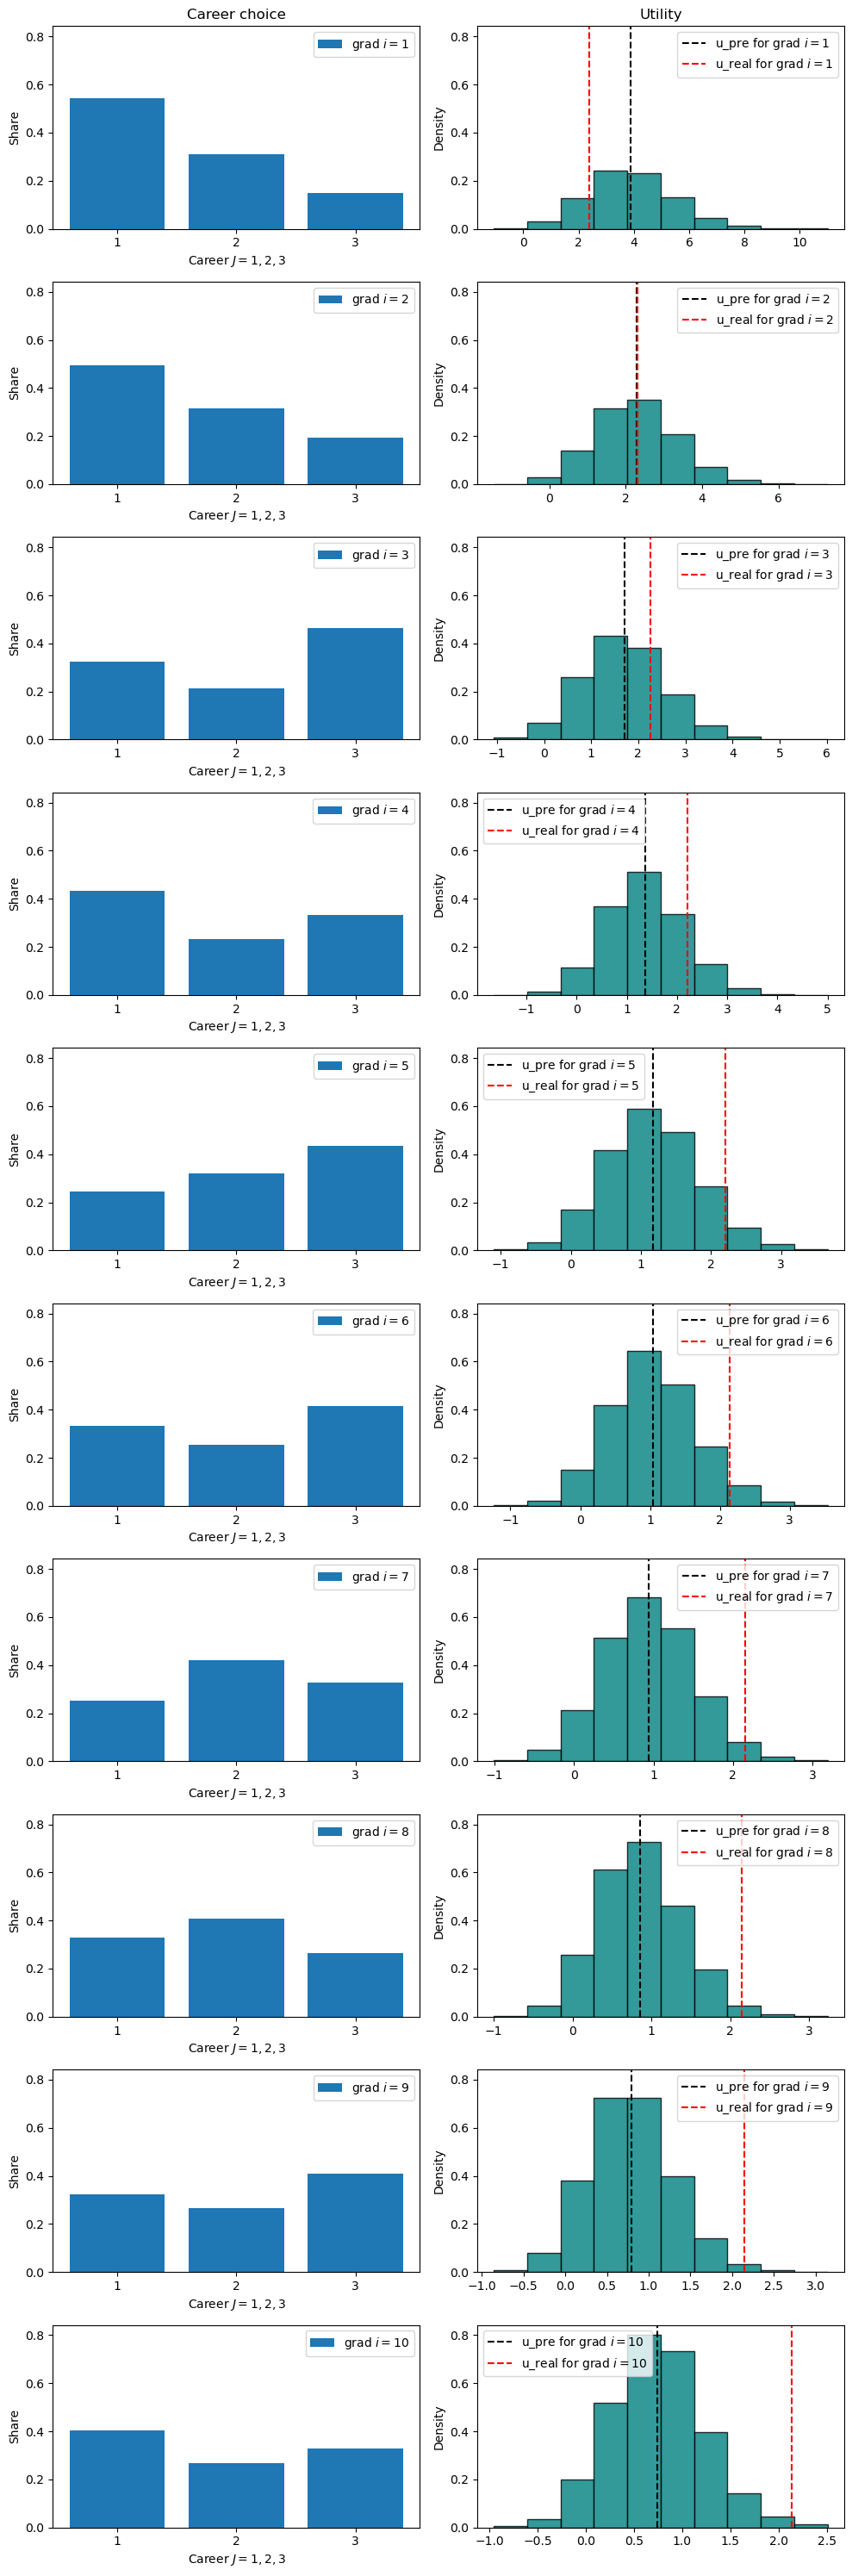

In [12]:
# Let's plot our results
fig, ax = plt.subplots(N, 2, figsize=(10,30), tight_layout=True, sharey=True)

# Compute the average by graduate
res_groupby_grad = tab4_long.groupby('grad_i').mean().reset_index()

for i in range(N):

    # Average expected utility prior to choice
    util_prior_mean = res_groupby_grad[res_groupby_grad['grad_i']==i+1]['util_prior'][i]
    # Utility prior to choice (to see distribution)
    util_pre = tab4_long[tab4_long['grad_i']==i+1]['util_prior']

    # Average realized utility 
    util_real_mean = res_groupby_grad[res_groupby_grad['grad_i']==i+1]['util_real'][i]

    # Share of career choice
    career_J = careers_by_grad[careers_by_grad['grad_i']==i+1]['share']

    
    ax[0, 0].set_title('Career choice')
    ax[0, 1].set_title('Utility')
    ax[i, 0].bar([1, 2, 3], career_J, label=f'grad $i={i+1}$')
    ax[i, 1].hist(util_pre, density=True, bins=10, edgecolor='k', alpha=0.8, color='teal')
    ax[i, 1].axvline(util_prior_mean, color='k', linestyle='--', label=f'u_pre for grad $i={i+1}$')
    ax[i, 1].axvline(util_real_mean, color='r', linestyle='--', label=f'u_real for grad $i={i+1}$')
    ax[i, 1].legend(fontsize=10)
    ax[i, 0].legend(fontsize=10)
    ax[i, 0].set_xlabel(r'Career $J=1, 2, 3$')
    ax[i, 0].set_xticks([1, 2, 3])
    ax[i, 0].yaxis.set_tick_params(which='both', labelleft=True)
    ax[i, 1].yaxis.set_tick_params(which='both', labelleft=True)
    ax[i, 0].set_ylabel('Share')
    ax[i, 1].set_ylabel('Density')

Here, we notice that for graduates with a high number of friends, the expected value is noticeably lower than the realized utility value. This is because they lose the information of $v_i$ and thus the more friends they have, the variance of their prior distribtion decreases and vice versa. In "utility-terms", they are "over-optimistic" with few friends (less than 2) and too "pessimistic"/conservative with relatively high amount friends.

----

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [13]:
res = []

# Same procedure as before.

for i in range(N):
    eps_fjk = np.random.normal(0, sigma, size = J * F[i] * K).reshape(F[i], J, K) # F[i], J, K
    u_bar_ijk = 1/F[i] * (v.reshape(-1,1) + eps_fjk.sum(axis=0)) # J, K
    career_choice = u_bar_ijk.argmax(axis=0) # K
    util_prior = u_bar_ijk[career_choice, helper_idx] # J, K
    eps_ijk = np.random.normal(0, sigma, size=J * K).reshape(J, K) # J, K
    util_real = v[career_choice] + eps_ijk[career_choice, :].mean()

    # New component, introduce cost
    u_bar_ijk_2 = u_bar_ijk.copy()
    u_bar_ijk_2 = u_bar_ijk_2-c

    # Based on their previous choice, replace the utility in u_bar_ijk_2
    u_bar_ijk_2[career_choice, helper_idx] = util_real

    # Then compute who like to switch
    switch = u_bar_ijk_2 > util_real
    stay = util_real > u_bar_ijk_2

    # Save the new career choice and switch indicies
    new_career_switchers, switchers_idx=np.where(switch == True)
    career1_switchers = career_choice[switchers_idx]
    n_switchers = len(switchers_idx)
    n_switchers_idx = np.arange(n_switchers)

    final_util = util_real.copy()

    # Replace the (final) utility for the switchers
    final_util[switchers_idx] = u_bar_ijk_2[:, switchers_idx][new_career_switchers, n_switchers_idx]

    grad = i+1

    res.append({
            'career': (career_choice+1),
            'util_prior': util_prior,
            'util_real': util_real,
            'start_career_switchers': career1_switchers, 
            'new_career_switchers': new_career_switchers,
            'final_util': final_util,
            'grad_i': grad 
        })

tab5 = pd.DataFrame(res)

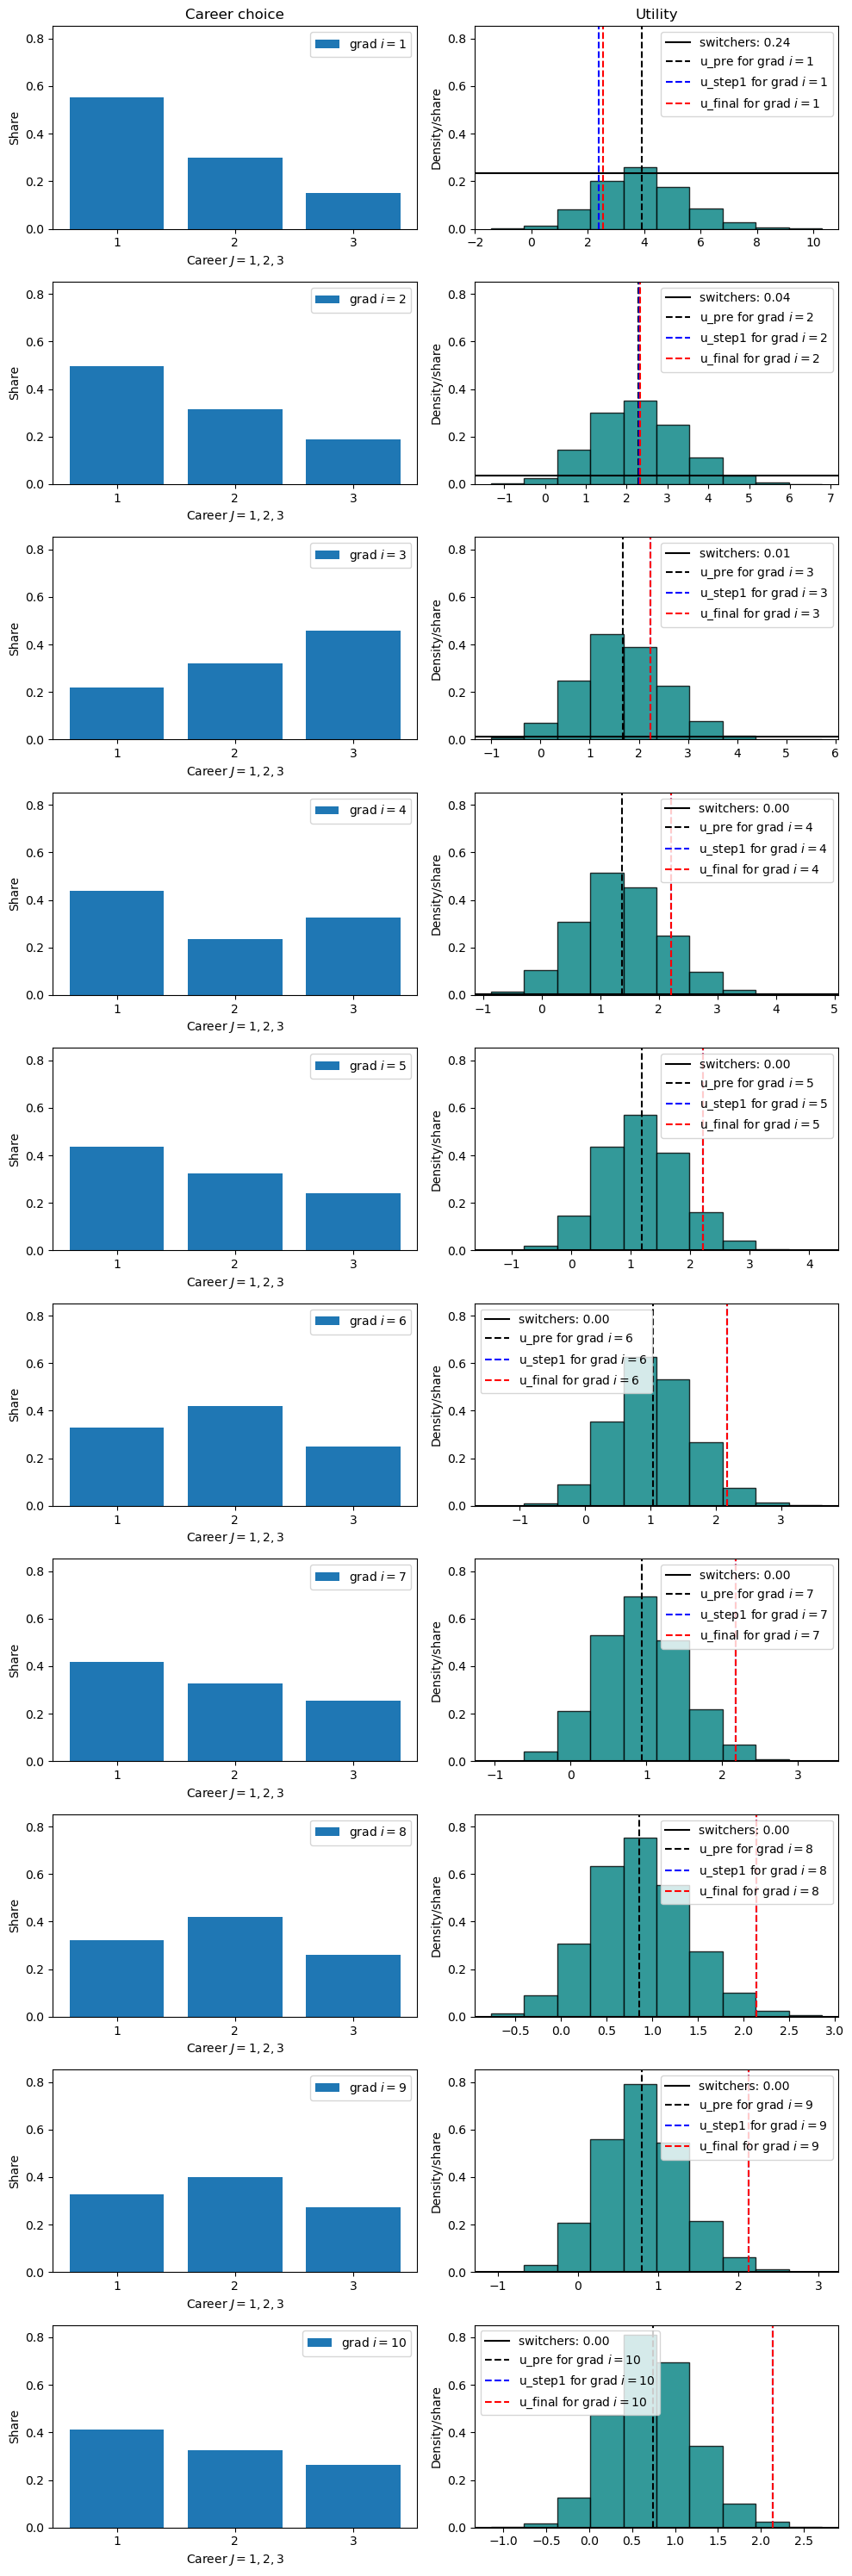

In [14]:
# Make long version and compute mean by grad type
tab5_long = tab5[['career', 'util_prior', 'util_real', 'final_util', 'grad_i']].explode(['career', 'util_prior', 'util_real', 'final_util'])

careers_by_grad=tab5_long.value_counts(['career', 'grad_i']).reset_index().sort_values('grad_i').reset_index(drop=True)
careers_by_grad['share']=careers_by_grad['count']/K

res_groupby_grad = tab5_long.groupby('grad_i').mean().reset_index()


# Plot results
fig, ax = plt.subplots(N, 2, figsize=(10,30), tight_layout=True, sharey=True)

for i in range(N):

    util_prior_mean = res_groupby_grad[res_groupby_grad['grad_i']==i+1]['util_prior'][i]
    util_real_mean = res_groupby_grad[res_groupby_grad['grad_i']==i+1]['util_real'][i] 
    util_final_mean = res_groupby_grad[res_groupby_grad['grad_i']==i+1]['final_util'][i] # Now with "final" utility
    career_J = careers_by_grad[careers_by_grad['grad_i']==i+1]['share']
    share_of_switchers = tab5[tab5['grad_i']==i+1]['new_career_switchers'][i].shape[0]/K
    util_pre = tab5_long[tab5_long['grad_i']==i+1]['util_prior']

    ax[0, 0].set_title('Career choice')
    ax[0, 1].set_title('Utility')
    ax[i, 0].bar([1, 2, 3], career_J, label=f'grad $i={i+1}$')
    ax[i, 1].axhline(share_of_switchers, label=f'switchers: {share_of_switchers:.2f}', color='k')
    ax[i, 1].hist(util_pre, density=True, bins=10, edgecolor='k', alpha=0.8, color='teal')
    ax[i, 1].axvline(util_prior_mean, color='k', linestyle='--', label=f'u_pre for grad $i={i+1}$')
    ax[i, 1].axvline(util_real_mean, color='b', linestyle='--', label=f'u_step1 for grad $i={i+1}$')
    ax[i, 1].axvline(util_final_mean, color='r', linestyle='--', label=f'u_final for grad $i={i+1}$')
    ax[i, 1].legend(fontsize=10)
    ax[i, 0].legend(fontsize=10)
    ax[i, 0].set_xlabel(r'Career $J=1, 2, 3$')
    ax[i, 0].set_xticks([1, 2, 3])
    ax[i, 0].yaxis.set_tick_params(which='both', labelleft=True)
    ax[i, 1].yaxis.set_tick_params(which='both', labelleft=True)
    ax[i, 0].set_ylabel('Share')
    ax[i, 1].set_ylabel('Density/share')

Here, we notice that only graduates with a low number of friends (less than 2) decide to switch careers. This follows directly from what we observed above. They are too "pessimistic" in the first step and can, on average, benefit from switching careers. ~20 percent of those graduates who base their expectation on $F=1$ friend(s) decide to switch careers. Graphically, we see that by the move from the blue to red dotted line.

----

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [15]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


In [16]:
y

array([0.20901926, 0.37774759])

**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

In [17]:
# Define the objective function (the euclidean distance)
def eucl_dist(X):
    return np.sqrt((X[0]-y[0])**2 + (X[1]-y[1])**2)

# Adding an error term to add to the constraint to ensure numerical convergence
err = 0.01

# x1 > y1
def constraint_1_1(X):
    return X[0]-y[0]-err

# y1 > x1
def constraint_1_2(X):
    return y[0]-X[0]-err

# x2 > y2
def constraint_2_1(X):
    return X[1] - y[1]-err

# y2 > x2
def constraint_2_2(X):
    return y[1] - X[1]-err

# x1 > y1 & x2 > y2
constraints_A = [{'type': 'ineq', 'fun': constraint_1_1},
               {'type': 'ineq', 'fun': constraint_2_1}] 

# x1 > y1 & x2 < y2
constraints_B = [{'type': 'ineq', 'fun': constraint_1_1},
               {'type': 'ineq', 'fun': constraint_2_2}] 

# x1 < y1 & x2 < y2
constraints_C = [{'type': 'ineq', 'fun': constraint_1_2},
               {'type': 'ineq', 'fun': constraint_2_2}] 

# x1 < y1 & x2 > y2
constraints_D = [{'type': 'ineq', 'fun': constraint_1_2},
               {'type': 'ineq', 'fun': constraint_2_1}] 

# Compute A, B, C, D
res_A=optimize.minimize(eucl_dist, x0=(0.1,0.1), constraints=constraints_A)
A = res_A.x
x1A, x2A = A

res_B=optimize.minimize(eucl_dist, x0=(0.1,0.1), constraints=constraints_B)
B = res_B.x
x1B, x2B = B

res_C=optimize.minimize(eucl_dist, x0=(0.1,0.1), constraints=constraints_C)
C = res_C.x
x1C, x2C = C

res_D=optimize.minimize(eucl_dist, x0=(0.1,0.1), constraints=constraints_D)
D = res_D.x
x1D, x2D = D

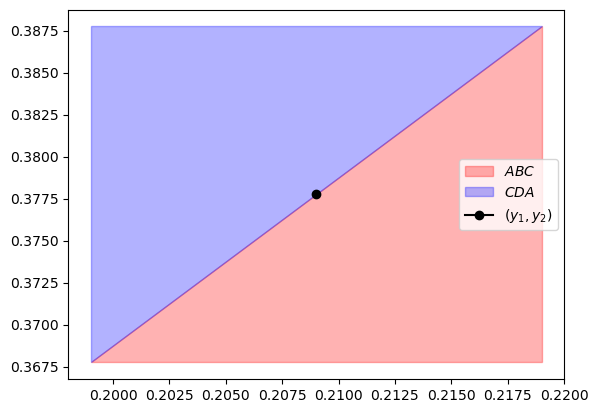

In [18]:
# Illustrate our results
fig, ax = plt.subplots()

ax.fill([x1A, x1B, x1C], [x2A, x2B, x2C], color='r', alpha=0.3, label=r'$ABC$')
ax.fill([x1C, x1D, x1A], [x2C, x2D, x2A], color='b', alpha=0.3, label=r'$CDA$')
ax.plot(y[0], y[1], marker='o', color='black', label=fr'$(y_1, y_2)$')
ax.legend()

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [19]:
def bary_coords(I, J, K, y):
    '''
    Computes the barycentric coordinates. Insert args I, J, K to define triangle IJK.
    '''
    r1 = ((J[1]-K[1])*(y[0]-K[0])+(K[0]-J[0])*(y[1]-K[1]))/((J[1]-K[1])*(I[0]-K[0])+(K[0]-J[0])*(I[1]-K[1]))

    r2 = ((K[1]-I[1])*(y[0]-K[0])+(I[0]-K[0])*(y[1]-K[1]))/((J[1]-K[1])*(I[0]-K[0])+(K[0]-J[0])*(I[1]-K[1]))

    r3 = 1-r1-r2

    return r1, r2, r3

ABC_coords = bary_coords(A, B, C, y)
CDA_coords = bary_coords(C, D, A, y)


def check_coords(coords):
    '''
    Checks coordinates in [0, 1]
    '''
    coords = np.array([coords])
    return np.all((coords >= 0) & (coords <=1))

y0, y1 = y

if check_coords(ABC_coords)==True:
    print(f'the points y = ({y0:.2f}, {y1:.2f}) is in triangle ABC')
elif check_coords(CDA_coords)==True:
    print(f'the points y = ({y0:.2f}, {y1:.2f}) is in triangle CDA')

the points y = (0.21, 0.38) is in triangle CDA


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [20]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [21]:
def bary_interp(X, y, f):

    '''
    Computes the full barocentric interpolation algorithm.
    '''

    # Compute results
    res_A=optimize.minimize(eucl_dist, x0=(0.1,0.1), constraints=constraints_A)
    A = res_A.x
    x1A, x2A = A

    res_B=optimize.minimize(eucl_dist, x0=(0.1,0.1), constraints=constraints_B)
    B = res_B.x
    x1B, x2B = B

    res_C=optimize.minimize(eucl_dist, x0=(0.1,0.1), constraints=constraints_C)
    C = res_C.x
    x1C, x2C = C

    res_D=optimize.minimize(eucl_dist, x0=(0.1,0.1), constraints=constraints_D)
    D = res_D.x
    x1D, x2D = D
    
    # Compute triangles
    ABC_coords = bary_coords(A, B, C, y)
    CDA_coords = bary_coords(C, D, A, y)

    # Which does triangle does the triangle belong to?
    if check_coords(ABC_coords)==True:
        r1, r2, r3 = ABC_coords
        return r1 * f(A) + r2 * f(B) + r3 * f(C)
    elif check_coords(CDA_coords)==True:
        r1, r2, r3 = CDA_coords
        return r1 * f(C) + r2 * f(D) + r3 * f(A)

In [23]:
interp_val = bary_interp(X, y, f)
true_val = f(y)
err = abs(interp_val-true_val)

print(f'The barycentric algorithm approximates f(y) with an error of {err:.7f}')

The barycentric algorithm approximates f(y) with an error of 0.0001000


**Question 4:** Repeat question 3 for all points in the set $Y$.

In [24]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [25]:
res = []

for y in Y:
    interp_val = bary_interp(X, y, f)
    true_val = f(y)
    y1, y2 = y
    res.append({
        'Interpolated': interp_val,
        'True': true_val,
        '(y1, y2)': (y1, y2)
    })

tab6 = pd.DataFrame(res)
tab6

,Interpolated,True,"(y1, y2)"
0,0.04,0.04,"(0.2, 0.2)"
1,0.16,0.16,"(0.8, 0.2)"
2,0.64,0.64,"(0.8, 0.8)"
3,0.16,0.16,"(0.8, 0.2)"
4,0.25,0.25,"(0.5, 0.5)"


Again, we see that the barycentric interpolation algorithm approximates f(y) with strong precision.